In [2]:
import QuantLib as ql
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as spo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from random import sample
import sklearn.neural_network as sknn
import matplotlib.pyplot as plt
import time
from scipy.integrate import *
import cmath as cpx
import math as m
from sklearn.metrics import mean_squared_error
from copy import deepcopy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def MakeUniformRandParams(ArrayMin,ArrayMax,nRand):
    if (len(ArrayMin)!=len(ArrayMax)):
        raise Exception('ArrayMax and ArrayMin must have the same size')
    else:
        nParams = len(ArrayMin)
        rand_seq = ql.UniformRandomSequenceGenerator(nParams*nRand,ql.UniformRandomGenerator())
        X = rand_seq.nextSequence().value()
        #X = [ArrayMin[j%nParams]+(ArrayMax[j%nParams]-ArrayMin[j%nParams])*X[j] for j in range(nParams*nRand)]
        res = np.zeros((nRand,nParams))
        LocalMax = 0
        res__ = 0
        res_ = 0
        for i in range(nRand):
            for j in range(nParams):
                AdjMax = ArrayMax[j]
                if j==2:
                    AdjMax = XiFellerAdjust(res__,res_,ArrayMax[j])
                res[i,j]=ArrayMin[j]+(AdjMax-ArrayMin[j])*X[i*nParams+j]
                res__ = res_
                res_ = res[i,j]
        #res = np.reshape(X,(nRand,nParams))
        return res

def CountNoFellerCondition(X):
    k=0
    for j in range(len(X)):
        if (X[j,2]>XiFellerMax(X[j,0],X[j,1])):
            k=k+1
    return k

def XiFellerMax(kappa,theta):
    return m.sqrt(2*kappa*theta)

def XiFellerAdjust(kappa,theta,xi_init):
    if (xi_init>XiFellerMax(kappa,theta)):
        return XiFellerMax(kappa,theta)
    return xi_init
    
ArrayMin = [0.1, 0.1,  0.01, -0.999, 0.1]
ArrayMax = [1.5, 1.5,  0.75,  0.999, 1.5]
nRand = 100000
start = time.time()
res=MakeUniformRandParams(ArrayMin,ArrayMax,nRand)
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')
print('No Feller Condition ' + str(CountNoFellerCondition(res)))

Total computation time = 0.62s
No Feller Condition 0


In [4]:
# GLOBAL CONFIG #
AsOfDate = ql.Date(15,10,2018)
ql.Settings.instance().evaluationDate = AsOfDate
DayCount = ql.Actual365Fixed()
Calendar = ql.UnitedStates()

In [5]:
# EUROPEAN OPTION CONFIG #
MaturityDates = []
strikes = []
exercises = []
payoffs = []
option_type = ql.Option.Call
ms = [1,2,3,6,0,6,0,0,0,0]
ys = [0,0,0,0,1,1,2,3,4,5]
for k in range(len(ms)):
    if (10+ms[k]>12):
        ys_sup=1
    else:
        ys_sup=0
    MaturityDates.append(ql.Date(15,(10+ms[k]-1)%12+1,2018+ys[k]+ys_sup))
    exercises.append(ql.EuropeanExercise(MaturityDates[k]))
for k in range(7):
        strikes.append(70+k*10)
        #payoffs.append(ql.PlainVanillaPayoff(option_type, strikes[k]))
print(MaturityDates)
print(strikes)
EuropeanOptions = []
for K in range(len(strikes)):
    for T in range(len(MaturityDates)):
        EuropeanOptions.append(ql.VanillaOption(ql.PlainVanillaPayoff(option_type,100-(100-strikes[K])*m.sqrt((MaturityDates[T]-AsOfDate)/365)), exercises[T]))
#print(EuropeanOptions)

[Date(15,11,2018), Date(15,12,2018), Date(15,1,2019), Date(15,4,2019), Date(15,10,2019), Date(15,4,2020), Date(15,10,2020), Date(15,10,2021), Date(15,10,2022), Date(15,10,2023)]
[70, 80, 90, 100, 110, 120, 130]


In [6]:
def d1(S0, K, r, sigma, T):
    m = S0/(K*np.exp(-r*T))
    return np.log(m)*(1/(sigma*np.sqrt(T)))+sigma*np.sqrt(T)/2

def d2(S0, K, r, sigma, T):
    return d1(S0,K,r,sigma,T)-sigma*np.sqrt(T)
 
def BS_CallPrice(S0,K,r,sigma,T):
    if T==0:
        return np.maximum(S0-K,0)
    else:
        return S0*stats.norm.cdf(d1(S0,K,r,sigma,T))-K*np.exp(-r*T)*stats.norm.cdf(d2(S0,K,r,sigma,T))

def Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho):
    alpha = complex(-omega**2 / 2, -omega / 2)
    beta = complex(kappa,-rho*ksi*omega)
    gamma = ksi**2 / 2
    h = (beta**2-4*alpha*gamma)**0.5
    r_m = (beta-h) / ksi**2
    r_p = (beta+h) / ksi**2
    g = r_m / r_p
    C = kappa*(r_m*t-2*cpx.log((1-g*cpx.exp(-h*t))/(1-g))/ksi**2)
    D = r_m*((1-cpx.exp(-h*t))/(1-g*cpx.exp(-h*t)))
    return cpx.exp(complex(C*theta+D*v0,omega*np.log(S0*np.exp(r*t))))

def RPI1_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega-complex(0,1),S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega*Heston_CharacteristicFunctionLogPrice(t,-complex(0,1),S0,v0,r,kappa,theta,ksi,rho))
    return (num / denom).real
def RPI2_HestonChFuncLnS(omega,K,t,S0,v0,r,kappa,theta,ksi,rho):
    num = Heston_CharacteristicFunctionLogPrice(t,omega,S0,v0,r,kappa,theta,ksi,rho)*cpx.exp(complex(0,-omega*np.log(K)))
    denom = complex(0,omega)
    return (num / denom).real
def Heston_CallPrice(K,S0,r,T,v0,kappa,theta,ksi,rho):
    Pi_1 = 1/2+1/np.pi*quad(RPI1_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    Pi_2 = 1/2+1/np.pi*quad(RPI2_HestonChFuncLnS,0,np.inf,args=(K,T,S0,v0,r,kappa,theta,ksi,rho))[0]
    return S0*Pi_1-K*np.exp(-r*T)*Pi_2

def IVol(Mkt,S0,K,r,T,vol0=0.1):
    def f(vol,Mkt_,S0_,K_,r_,T_,type_): return (BS_CallPrice(S0_,K_,r_,vol,T_)-Mkt)**2
    return spo.minimize(f,vol0,args=(Mkt,S0,K,r,T,type),tol=1.0e-10).x

In [7]:
#OLD
Expiries = [0.0833,0.1667,0.25,0.5,1,1.5,2,3,4,5]
BaseStrikes = [70,80,90,100,110,120,130]
Strikes = []
for K in range(len(BaseStrikes)):
    for T in range(len(Expiries)):
        Strikes.append(100-(100-BaseStrikes[K])*m.sqrt(Expiries[T])) 

In [8]:
# MARKET DATA
r=ql.SimpleQuote(0.01)
r_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(r),DayCount)
q=ql.SimpleQuote(0.0)
q_ts = ql.FlatForward(0,Calendar,ql.QuoteHandle(q),DayCount)
s0=ql.SimpleQuote(100)

# BLACK SCHOLES ENGINE ONLY USED FOR COMPUTING IMPLIED VOLATILITIES
vol_bs = ql.SimpleQuote(0.10)
vol_bs_ts = ql.BlackConstantVol(0,Calendar,ql.QuoteHandle(vol_bs),DayCount)
BSProcess = ql.BlackScholesMertonProcess(ql.QuoteHandle(s0),ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                               ql.BlackVolTermStructureHandle(vol_bs_ts))

# HESTON ENGINE
v0 = 0.01
kappa=0.5
theta=0.01
sigma=0.0001
rho=-0.5
HestonParams = [theta,kappa,sigma,rho,v0]
relTolerance=0.01
maxEval=10000
HestonProcess = ql.HestonProcess(ql.YieldTermStructureHandle(r_ts),ql.YieldTermStructureHandle(q_ts),
                                 ql.QuoteHandle(s0),v0,kappa,theta,sigma,rho)
HestonModel = ql.HestonModel(HestonProcess)
HestonEngine = ql.AnalyticHestonEngine(HestonModel,relTolerance,maxEval)
for i in range(len(EuropeanOptions)):
    EuropeanOptions[i].setPricingEngine(HestonEngine)

In [9]:
# GENERATE DATAS
nRand = 100000
start = time.time()
MinParamsValues = [0.1,0.1,0.1,-0.999,0.1]
MaxParamsValues = [2.5,0.6,1.5,-0.10,0.6]
local_start = 0
local_end = 0
ArrParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)
intermediary = time.time()

#npv = np.zeros(nRand)
#iv = np.zeros(nRand)
#for i in range(nRand):
#    HestonModel.setParams([ArrParams[i][k] for k in range(len(MinParamsValues))])
#    npv[i] = EuropeanOption.NPV()
#    iv[i] = EuropeanOption.impliedVolatility(npv[i],BSProcess,1.0e-4,200,1.0e-8,10)
#end = time.time()
#print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
#print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
#print('Total computation time = ' + str(round(end-start,2)) + 's')
#X = np.zeros((nRand*len(Strikes),len(ArrParams[0])+2))
npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([ArrParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
end = time.time()
print('Random params simulation time = ' + str(round(intermediary-start,2)) + 's')
print('Prices computation time = ' + str(round(end-intermediary,2)) + 's')
print('Total computation time = ' + str(round(end-start,2)) + 's')

Random params simulation time = 0.65s
Prices computation time = 594.51s
Total computation time = 595.16s


In [58]:
HestonPrice = EuropeanOptions[j].NPV()
time_=ql.Date(15,11,2018)-AsOfDate
print(time_)
print(EuropeanOptions[j])

31
<QuantLib.QuantLib.VanillaOption; proxy of <Swig Object of type 'VanillaOptionPtr *' at 0x00000263EC97A2D0> >


In [60]:
print(HestonPrice)
print('K = ' + str(strikes[j%len(strikes)]))
print('T = ' + str(MaturityDates[int(j/len(strikes))]))
print(ArrParams[i])
new_vol = 100
vol_bs.setValue(new_vol)
EuropeanOptions[j].setPricingEngine(ql.AnalyticEuropeanEngine(BSProcess))
print(EuropeanOptions[j].NPV())

97.3865967715769
K = 70
T = October 15th, 2028
[ 0.87791359  0.57905022  0.85163063 -0.6712743   0.47793902]
90.47630508934425


In [10]:
def ann_layers_neurones(layer, neurone):
    hidden_layer_sizes = (neurone, )
    if layer == 1.0: return hidden_layer_sizes
    elif layer > 1.0:
        for i in range(layer-1):
            hidden_layer_sizes += (neurone,)
        return hidden_layer_sizes

nLayersMin = 3
nLayersMax = 5
nLayersStep = 1
nNeuronesMin = 30
nNeuronesMax = 60
nNeuronesStep = 5
hidden_layers_sizes_vect = []
i_ = 0
for i in range(nNeuronesMin,nNeuronesMax+1,nNeuronesStep):
    j_ = 0
    for j in range(nLayersMin,nLayersMax+1,nLayersStep):
        hidden_layers_sizes_vect.append(ann_layers_neurones(j,i))
        j_ += 1
    i_ += 1
print(hidden_layers_sizes_vect)

[(30, 30, 30), (30, 30, 30, 30), (30, 30, 30, 30, 30), (35, 35, 35), (35, 35, 35, 35), (35, 35, 35, 35, 35), (40, 40, 40), (40, 40, 40, 40), (40, 40, 40, 40, 40), (45, 45, 45), (45, 45, 45, 45), (45, 45, 45, 45, 45), (50, 50, 50), (50, 50, 50, 50), (50, 50, 50, 50, 50), (55, 55, 55), (55, 55, 55, 55), (55, 55, 55, 55, 55), (60, 60, 60), (60, 60, 60, 60), (60, 60, 60, 60, 60)]


In [11]:
start = time.time()
n = nRand
ann = sknn.MLPRegressor(hidden_layer_sizes=(30,30,30))
array_train_rel_error = np.zeros((n,len(EuropeanOptions)))
array_test_rel_error = np.zeros((n,len(EuropeanOptions)))
array_train_abs_error = np.zeros((n,len(EuropeanOptions)))
array_test_abs_error = np.zeros((n,len(EuropeanOptions)))
index = sample(range(0,nRand),n)
X=np.zeros((n,len(ArrParams[0])))
for k in range(len(ArrParams[0])):        
    X[:,k]=[ArrParams[j,k] for j in index]
Y=[iv[j,:] for j in index]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
X_train = X
Y_train = Y

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

# ANN FIT

mse_optim = 1000
ann_optim = deepcopy(ann)
for current_archi in hidden_layers_sizes_vect:
    ann.set_params(hidden_layer_sizes=current_archi)
    ann.fit(X_train,Y_train)
    train_prediction=ann.predict(X_train)
    mse=mean_squared_error(Y_train,train_prediction)
    print('current archi ' + str(current_archi) + ' ; mse = ' + str(mse))
    if (mse<mse_optim):
        mse_optim=mse
        print('I am optimal')
        ann_optim=deepcopy(ann)
        for i in range(len(X_train)):
            for j in range(len(EuropeanOptions)):
                array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
            
            #for j in range(len(EuropeanOptions)):
                #if (i < len(X_train)):
                    #array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                    #array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
                #if (i < len(X_test)):
                    #array_test_abs_error[i,j]=(test_prediction[i,j]-Y_test[i][j])*100
                    #array_test_rel_error[i,j]=(test_prediction[i,j]/Y_test[i][j]-1)*100
        
        #test_prediction=ann.predict(X_test)
        #for i in range(max(len(X_train),len(X_test))):
            #for j in range(len(EuropeanOptions)):
                #if (i < len(X_train)):
                    #array_train_abs_error[i,j]=(train_prediction[i,j]-Y_train[i][j])*100
                    #array_train_rel_error[i,j]=(train_prediction[i,j]/Y_train[i][j]-1)*100
                #if (i < len(X_test)):
                    #array_test_abs_error[i,j]=(test_prediction[i,j]-Y_test[i][j])*100
                    #array_test_rel_error[i,j]=(test_prediction[i,j]/Y_test[i][j]-1)*100
end = time.time()
print('Total computation time = ' + str(round(end-start,2)) + 's')

current archi (30, 30, 30) ; mse = 7.338847928721804e-05
I am optimal
current archi (30, 30, 30, 30) ; mse = 7.864287598893163e-05
current archi (30, 30, 30, 30, 30) ; mse = 0.00011100567205111486
current archi (35, 35, 35) ; mse = 6.961904568090849e-05
I am optimal
current archi (35, 35, 35, 35) ; mse = 5.1578016980543714e-05
I am optimal
current archi (35, 35, 35, 35, 35) ; mse = 9.624950990606048e-05
current archi (40, 40, 40) ; mse = 6.52372323363973e-05
current archi (40, 40, 40, 40) ; mse = 5.7089668911755286e-05
current archi (40, 40, 40, 40, 40) ; mse = 6.621874217466331e-05
current archi (45, 45, 45) ; mse = 5.045702783662754e-05
I am optimal
current archi (45, 45, 45, 45) ; mse = 4.60193391626149e-05
I am optimal
current archi (45, 45, 45, 45, 45) ; mse = 4.480222883269793e-05
I am optimal
current archi (50, 50, 50) ; mse = 6.012275680070682e-05
current archi (50, 50, 50, 50) ; mse = 4.792408233796158e-05
current archi (50, 50, 50, 50, 50) ; mse = 5.4641489415773154e-05
curre

Text(0.5,1,'Maximum Absolute Error')

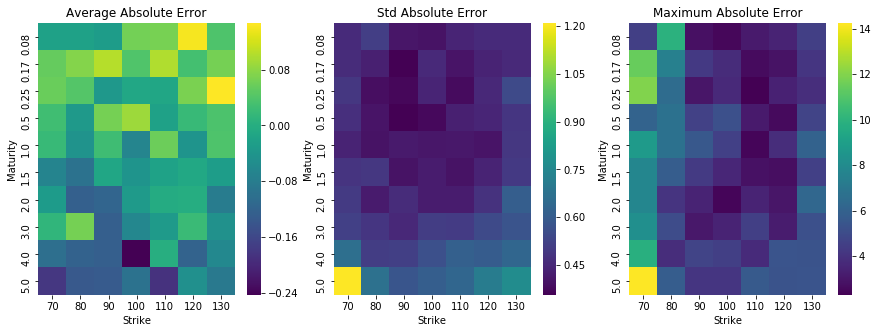

In [29]:
Expiries_ = np.zeros(len(Expiries))
for j in range(len(Expiries)):
    Expiries_[j] = round(Expiries[j],2)
plt.figure(figsize=(15,5))
plt.figure(1)

plt.subplot(131)
mean_abs_data = np.reshape(np.mean(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_mean_abs = pd.DataFrame(mean_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_mean_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Average Absolute Error")

plt.subplot(132)
std_abs_data = np.reshape(np.std(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_std_abs = pd.DataFrame(std_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_std_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Std Absolute Error")

plt.subplot(133)
max_abs_data = np.reshape(np.max(array_train_abs_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_max_abs = pd.DataFrame(max_abs_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_max_abs, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Maximum Absolute Error")

Text(0.5,1,'Maximum Relative Error')

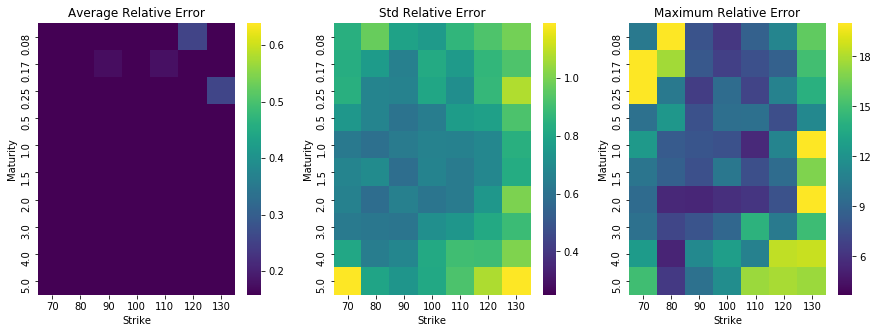

In [28]:
plt.figure(figsize=(15,5))
plt.figure(1)

plt.subplot(131)
mean_rel_data = np.reshape(np.mean(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_mean_rel = pd.DataFrame(mean_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_mean_rel, vmin=0.158, vmax=0.639, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Average Relative Error")

plt.subplot(132)
std_rel_data = np.reshape(np.std(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_std_rel = pd.DataFrame(std_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_std_rel, vmin=0.25, vmax=1.19, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Std Relative Error")

plt.subplot(133)
max_rel_data = np.reshape(np.max(array_train_rel_error,axis=0),(len(BaseStrikes),len(Expiries))).transpose()
df_max_rel = pd.DataFrame(max_rel_data,index=Expiries_,columns=BaseStrikes)
ax = sns.heatmap(df_max_rel, vmin=3.7, vmax=20, cmap='viridis')
plt.xlabel("Strike")
plt.ylabel("Maturity")
plt.title("Maximum Relative Error")

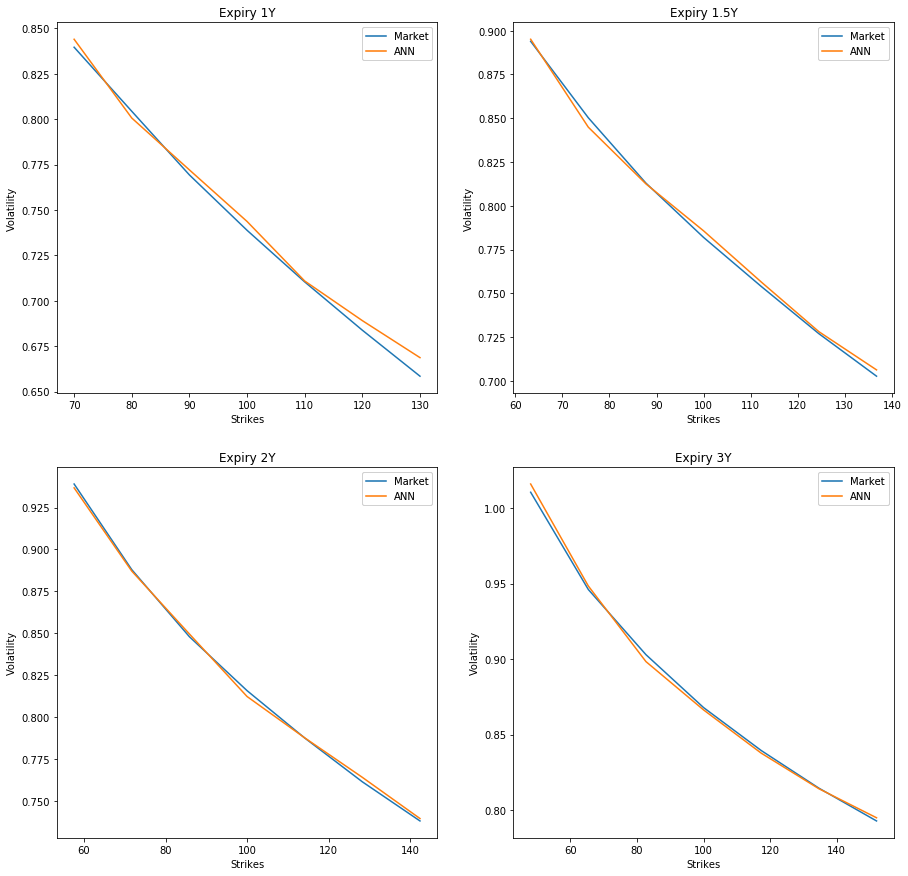

In [31]:
n = 1
index = sample(range(0,nRand),n)
X_ref=np.zeros((n,len(ArrParams[0])))
for k in range(len(ArrParams[0])):        
    X_ref[:,k]=[X_train[j,k] for j in index]
Y_ref=np.array(Y_train)[index,:]
Y_pred=ann.predict(X_ref)

X2 = np.reshape(np.tile(Expiries,len(BaseStrikes)),(len(BaseStrikes),len(Expiries)))
Y2 = np.reshape(np.array(Strikes),(len(BaseStrikes),len(Expiries)))

Z_INIT = np.reshape(Y_ref[0],(len(BaseStrikes),len(Expiries)))
Z_ANN = np.reshape(Y_pred[0],(len(BaseStrikes),len(Expiries)))
#print(X)
#print(Y)
#print(Z)
#surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

plt.figure(figsize=(15,15))
plt.figure(1)
current_num=221
for k in range(4,8):
    plt.subplot(current_num)
    line1, = plt.plot(Y2[:,k],Z_INIT[:,k],label="Market")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.title("Expiry " + str(round(Expiries[k],2)) + "Y")
    line2, = plt.plot(Y2[:,k],Z_ANN[:,k],label="ANN")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.gca().add_artist(plt.legend(handles=[line1,line2]))
    #plt.gca().add_artist(plt.legend(handles=[line2],loc=7))
    current_num = current_num+1

plt.show()

In [36]:
def EvalANN(params,ann_,output_): return mean_squared_error(output_,ann_.predict([params]))
def InvertANN(ann,mkt,scaler,params0=[0.5,0.25,0.3,-0.5,0.25]):
    Sparams0 = scaler.transform([params0])
    return spo.minimize(EvalANN,Sparams0,args=(ann,mkt),tol=1.0e-8)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    for j in range(len(EuropeanOptions)):
        npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
        iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertANN(ann_optim,iv,scaler)
end = time.time()
ann_iv = ann_optim.predict([res.x])
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(scaler.inverse_transform(res.x)))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('ANN Calibrated IV Surface : ' + str(ann_iv[0]*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv-ann_iv)[0]*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 0.24s
The optimal set of params is [ 1.6839819   0.17945671  0.57335247 -0.40578174  0.28807902]
The initial set of params is [ 1.56452381  0.16232086  0.24939788 -0.91998672  0.29163893]
The standard deviation on the surface is 0.19138943757886123%


Initial IV Surface : [ 56.80506317  58.27510605  59.56546391  62.7175207   67.9121925
  72.33124574  76.33773166  83.79687553  91.37318018 100.17870136
  56.27369889  57.53195252  58.65230061  61.43032171  66.05928816
  69.97172179  73.45800599  79.64890818  85.33879027  90.99839247
  55.81130306  56.88055952  57.85834178  60.33767079  64.56150403
  68.16213483  71.36264011  76.95877987  81.91564409  86.5801504
  55.38511803  56.29471641  57.14940067  59.38347635  63.30054158
  66.69326622  69.72285837  75.3128094   79.59772601  83.81539268
  54.99208343  55.75494395  56.50447301  58.53058331  62.20972152
  65.45771221  68.37393798  73.46071546  77.86473395  81.84689379
  54.6264292   55.25506632  55.9082035

In [43]:
def HestonIV(HestonModel_,Options_,BSProcess_):
    LocIV = np.zeros(len(Options_))
    for j in range(len(Options_)):
        npv = max(Options_[j].NPV(),np.random.uniform(0,0.01))
        LocIV[j] = Options_[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)
    return LocIV

def EvalHestonIV(params,HestonModel_,Options_,BSProcess_,RefIV_):
    HestonModel_.setParams([params[k] for k in range(len(params))])
    LocIV = HestonIV(HestonModel_,Options_,BSProcess_)
    return mean_squared_error(RefIV_,[LocIV])
        
def InvertHestonIV(HestonModel,RefIV,Options,BSProcess,params0=[0.5,0.25,0.3,-0.5,0.25]):
    return spo.minimize(EvalHestonIV,params0,args=(HestonModel,Options,BSProcess,RefIV),tol=1.0e-10)

nRand = 1
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    #for j in range(len(EuropeanOptions)):
    #    npv = max(EuropeanOptions[j].NPV(),np.random.uniform(0,0.01))
    #    iv[i,j] = EuropeanOptions[j].impliedVolatility(npv,BSProcess,1.0e-4,200,1.0e-8,100)

start = time.time()
res = InvertHestonIV(HestonModel,iv,EuropeanOptions,BSProcess)
end = time.time()
#print([res.x[k] for k in range(len(res.x))])
HestonModel.setParams([res.x[k] for k in range(len(res.x))])
opt_iv = HestonIV(HestonModel,EuropeanOptions,BSProcess)
print('Calibration computation time = ' + str(round(end-start,2)) + 's')
print('The optimal set of params is ' + str(res.x))
print('The initial set of params is ' + str(RefParams[0]))
print('The standard deviation on the surface is ' + str(m.sqrt(res.fun)*100) + '%')
print('\n')
print('Initial IV Surface : ' + str(iv[0]*100))
print('\n')
print('Calibrated IV Surface : ' + str(opt_iv*100))
print('\n')

print('Error ABS IV Surface : ' + str((iv[0]-opt_iv)*100))
#print('The optimal set of params is ' + str(res.x))
#EvalANN([0.5,0.25,0.3,-0.5,0.25],ann_optim,iv)

Calibration computation time = 5.2s
The optimal set of params is [ 1.37050853  0.46156663 -0.06332774 -0.22654322  0.53586261]
The initial set of params is [ 2.0843771   0.47052156  0.99096678 -0.52800936  0.5042626 ]
The standard deviation on the surface is 2.2725258941433646%


Initial IV Surface : [ 75.06761101  77.37128633  79.40604221  84.31985341  91.96086899
  97.91281097 102.92503814 111.70526223 120.30608281 132.86751655
  74.36915504  76.39641362  78.22343603  82.66887955  89.81894392
  95.32245323  99.77642228 107.26457823 114.00243407 121.27458406
  73.71715829  75.49945978  77.14730927  81.30717536  88.00773978
  93.27816141  97.55248791 104.37771058 110.15519067 115.86909354
  73.20248898  74.66951685  76.16552378  80.05242872  86.51898621
  91.60749456  95.74374703 102.25373247 107.57281698 112.57568326
  72.52937217  73.89944985  75.26111742  78.93193337  85.21399401
  90.21060626  94.24333589 100.60735412 105.66926775 110.28210173
  71.98578303  73.1829047   74.4312275

In [44]:
nRand = 10
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertHestonIV(HestonModel,[iv[i]],EuropeanOptions,BSProcess)
    end = time.time()
    err_params[i,:]=np.array(res.x)-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))

RuntimeError: root not bracketed: f[1e-08,100] -> [3.130202e+00,9.438730e+01]

In [47]:
nRand = 1000
RefParams = MakeUniformRandParams(MinParamsValues,MaxParamsValues,nRand)

npv = 0
iv = np.zeros((nRand,len(EuropeanOptions)))
times = np.zeros(nRand)
err_params = np.zeros((nRand,len(MinParamsValues)))
stdev = np.zeros(nRand)
for i in range(nRand):
    HestonModel.setParams([RefParams[i,k] for k in range(len(MinParamsValues))])
    iv[i,:] = HestonIV(HestonModel,EuropeanOptions,BSProcess)
    start = time.time()
    res = InvertANN(ann_optim,[iv[i]],scaler)
    end = time.time()    
    err_params[i,:]=np.array(scaler.inverse_transform(res.x))-RefParams[i]
    stdev[i] = m.sqrt(res.fun)*100
    times[i] = round(end-start,2)
    
print('mean stdev ' + str(np.mean(stdev)))
print('mean times ' + str(np.mean(times)))
print('mean err_params ' + str(np.mean(err_params,axis=0)))
print(RefParams)

mean stdev 0.3177004690633295
mean times 0.17944
mean err_params [-0.02880078 -0.01860752 -0.03721797 -0.0030844  -0.0008579 ]
[[ 0.31603818  0.51095909  0.22678841 -0.31472993  0.44679766]
 [ 1.86522312  0.50332485  0.74107018 -0.52719791  0.5883179 ]
 [ 0.84286646  0.45492002  0.52113049 -0.96314832  0.32566894]
 ...
 [ 2.06103763  0.50699693  0.64139463 -0.30484271  0.50901842]
 [ 2.20150046  0.42003838  0.43560235 -0.63007457  0.25741202]
 [ 1.22210616  0.10481841  0.30269538 -0.81823723  0.44149731]]


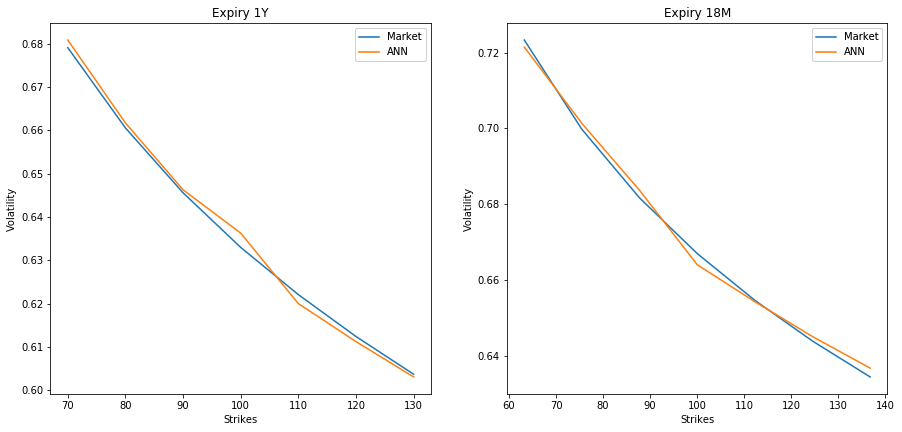

In [42]:
#fig = plt.figure()
#ax = fig.gca(projection='3d')
X = np.reshape(np.tile(Expiries,len(BaseStrikes)),(len(BaseStrikes),len(Expiries)))
Y = np.reshape(np.array(Strikes),(len(BaseStrikes),len(Expiries)))
Z_INIT = np.reshape(iv[0],(len(BaseStrikes),len(Expiries)))
Z_ANN = np.reshape(ann_iv,(len(BaseStrikes),len(Expiries)))
#print(X)
#print(Y)
#print(Z)
#surf = ax.plot_surface(X,Y,Z, cmap=cm.coolwarm,
                       #linewidth=0, antialiased=False)

plt.figure(figsize=(15,15))
plt.figure(1)
current_num=221
for k in range(4,6):
    plt.subplot(current_num)
    line1, = plt.plot(Y[:,k],Z_INIT[:,k],label="Market")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    if (k==4):
            plt.title("Expiry " + str(1) + "Y")
    else:
        plt.title("Expiry " + str(18) + "M")
    line2, = plt.plot(Y[:,k],Z_ANN[:,k],label="ANN")
    plt.xlabel("Strikes")
    plt.ylabel("Volatility")
    plt.gca().add_artist(plt.legend(handles=[line1,line2]))
    #plt.gca().add_artist(plt.legend(handles=[line2],loc=7))
    current_num = current_num+1

plt.show()

Text(0.5,1,'kappa')

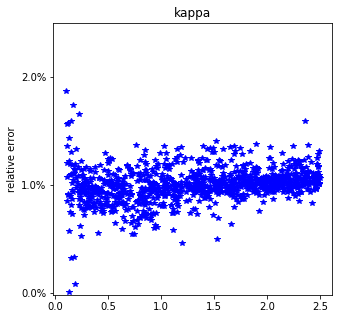

In [82]:
rel_err_params = np.zeros((nRand,len(err_params[0])))
for i in range(nRand):
    rel_err_params[i,:] = np.absolute(err_params[i,:]/RefParams[i,:]-1)

#print('mean stdev ' + str(np.mean(stdev)))
#print('mean times ' + str(np.mean(times)))
#print('mean err_params ' + str(np.mean(err_params,axis=0)))
plt.figure(figsize=(5,5))
plt.plot(RefParams[:,0], rel_err_params[:,0], 'b*')
axes = plt.gca()
axes.set_ylim(-0.02, 2.5)
axes.yaxis.set_ticks(range(0,3))
axes.yaxis.set_ticklabels(['0.0%','1.0%','2.0%'])
axes.xaxis.set_ticks([float(j)/2 for j in range(0,6)])
plt.ylabel("relative error")
plt.title("kappa")

Text(0.5,1,'theta')

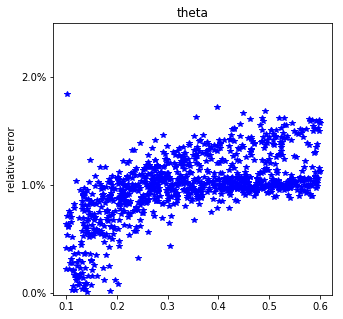

In [111]:
plt.figure(figsize=(5,5))
plt.plot(RefParams[:,1], rel_err_params[:,1], 'b*')
axes = plt.gca()
axes.set_ylim(-0.02, 2.5)
axes.yaxis.set_ticks(range(0,3))
axes.yaxis.set_ticklabels(['0.0%','1.0%','2.0%'])
axes.xaxis.set_ticks([float(j)/10 for j in range(1,7)])
plt.ylabel("relative error")
plt.title("theta")

Text(0.5,1,'xi')

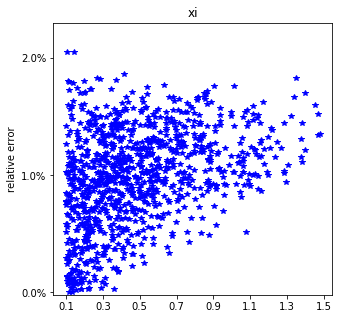

In [109]:
plt.figure(figsize=(5,5))
plt.plot(RefParams[:,2], rel_err_params[:,2], 'b*')
axes = plt.gca()
axes.set_ylim(-0.02, 2.3)
axes.yaxis.set_ticks(range(0,3))
axes.yaxis.set_ticklabels(['0.0%','1.0%','2.0%'])
axes.xaxis.set_ticks([float(j)/10 for j in range(1,17,2)])
plt.ylabel("relative error")
plt.title("xi")

Text(0.5,1,'rho')

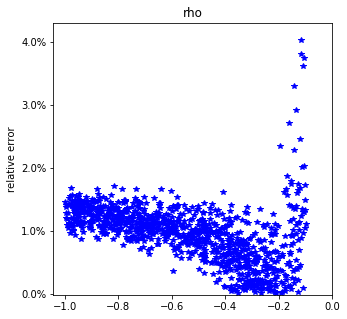

In [106]:
plt.figure(figsize=(5,5))
plt.plot(RefParams[:,3], rel_err_params[:,3], 'b*')
axes = plt.gca()
axes.set_ylim(-0.02, 4.3)
axes.yaxis.set_ticks(range(0,5))
axes.yaxis.set_ticklabels(['0.0%','1.0%','2.0%', '3.0%', '4.0%'])
axes.xaxis.set_ticks([-1+float(j)/5 for j in range(0,6)])
plt.ylabel("relative error")
plt.title("rho")

Text(0.5,1,'v0')

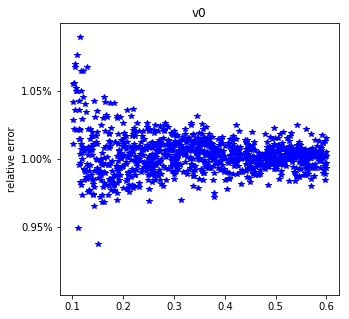

In [123]:
plt.figure(figsize=(5,5))
plt.plot(RefParams[:,4], rel_err_params[:,4], 'b*')
axes = plt.gca()
axes.set_ylim(0.9, 1.1)
axes.yaxis.set_ticks([0.95+(float(j)/20) for j in range(0,3)])
axes.yaxis.set_ticklabels(['0.95%','1.00%','1.05%'])
axes.xaxis.set_ticks([float(j)/10 for j in range(1,7)])
plt.ylabel("relative error")
plt.title("v0")